In [178]:
import tensorflow as tf
import keras
from keras import layers
from random import randint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [97]:
IMG_SIZE = (224, 224)
batch_size = 32
validation_split = 0.2

In [98]:
seed = randint(0, 2**32 - 1)

In [99]:
dataDir = 'datasets/processed'
baseWeightsSavePath = 'weights/best.keras'
baseFinetunedSavePath = 'weights/best_finetuned.keras'

In [100]:
tf.config.list_physical_devices("GPU")

[]

In [101]:
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet"
)
# Freeze the base model initially
base_model.trainable = False


In [102]:
train_ds = keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    label_mode="categorical",
)

val_ds = keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    label_mode="categorical",
)

# Create data augmentation layer
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.15, fill_mode="nearest"),
        layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
        layers.RandomZoom(0.1, fill_mode="nearest"),
        layers.RandomFlip("horizontal"),
        layers.RandomBrightness(0.3),
    ]
)


# Apply augmentation only to training dataset
def augment_images(image, label):
    return data_augmentation(image, training=True), label


# Normalize pixel values to [0,1]
normalization_layer = layers.Rescaling(1.0 / 255)

# Process training dataset (with augmentation)
train_ds = (
    train_ds.map(lambda x, y: (normalization_layer(x), y))
    .map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Process validation dataset (without augmentation)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(
    buffer_size=tf.data.AUTOTUNE
)


Found 1765 files belonging to 3 classes.
Using 1412 files for training.
Found 1765 files belonging to 3 classes.
Using 353 files for validation.


In [103]:
checkpoint_callback_base = keras.callbacks.ModelCheckpoint(
    filepath=baseWeightsSavePath,
    monitor="val_accuracy",  # You can use 'val_loss' for less overfitting
    save_best_only=True,  # Critical: only save if validation improves
    save_weights_only=False,  # Save entire model (architecture + weights)
    mode="max",  # 'max' for accuracy, 'min' for loss
    verbose=1,
)

checkpoint_callback_finetune = keras.callbacks.ModelCheckpoint(
    filepath=baseFinetunedSavePath,
    monitor="val_accuracy",  # You can use 'val_loss' for less overfitting
    save_best_only=True,  # Critical: only save if validation improves
    save_weights_only=False,  # Save entire model (architecture + weights)
    mode="max",  # 'max' for accuracy, 'min' for loss
    verbose=1,
)

# Callback 2: Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,  # Stop after 5 epochs without improvement
    restore_best_weights=True,  # Keep the best weights when stopping
)

# Callback 3: Reduce learning rate when plateauing
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # Wait 3 epochs
    min_lr=1e-7,  # Minimum learning rate
)

callbacks = [early_stop, reduce_lr]

In [104]:
model = keras.Sequential(
    [
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(3, activation="softmax"),
    ]
)

In [105]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), # pyright: ignore[reportArgumentType]
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [106]:
history = model.fit(
    train_ds,
    epochs=15,  # Initial phase
    validation_data=val_ds,
    callbacks=[checkpoint_callback_base, *callbacks],
)


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.4331 - loss: 1.1857
Epoch 1: val_accuracy improved from None to 0.52975, saving model to weights/best.keras

Epoch 1: finished saving model to weights/best.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 680ms/step - accuracy: 0.4490 - loss: 1.0834 - val_accuracy: 0.5297 - val_loss: 0.8988 - learning_rate: 0.0010
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.4572 - loss: 0.9783
Epoch 2: val_accuracy did not improve from 0.52975
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 626ms/step - accuracy: 0.4625 - loss: 0.9634 - val_accuracy: 0.4703 - val_loss: 0.8837 - learning_rate: 0.0010
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.4758 - loss: 0.9558
Epoch 3: val_accuracy did not improve from 0.52975
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 671ms/step - accuracy: 0.4809 - loss: 0.9506 - val_accuracy: 0.4986 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.4724 -

In [113]:
validation_loss, validation_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {validation_accuracy:.2%}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 447ms/step - accuracy: 0.5581 - loss: 0.8751
Validation Accuracy: 55.81%


In [108]:
model.load_weights(baseWeightsSavePath)

In [109]:
base_model.trainable = True

fine_tune = 40
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= len(base_model.layers) - fine_tune

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Much smaller LR # pyright: ignore[reportArgumentType]
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

print(f"\nPhase 2: Fine-tuning last {fine_tune} layers...")
history_fine = model.fit(
    train_ds,
    initial_epoch=history.epoch[-1],
    epochs=20,
    validation_data=val_ds,
    callbacks=[checkpoint_callback_finetune, *callbacks],
)



Phase 2: Fine-tuning last 40 layers...
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4407 - loss: 0.9730
Epoch 7: val_accuracy improved from None to 0.52975, saving model to weights/best_finetuned.keras

Epoch 7: finished saving model to weights/best_finetuned.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4469 - loss: 0.9667 - val_accuracy: 0.5297 - val_loss: 0.8956 - learning_rate: 1.0000e-05
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4783 - loss: 0.9629
Epoch 8: val_accuracy improved from 0.52975 to 0.53258, saving model to weights/best_finetuned.keras

Epoch 8: finished saving model to weights/best_finetuned.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4795 - loss: 0.9472 - val_accuracy: 0.5326 - val_loss: 0.8916 - learning_rate: 1.0000e-05
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4607 - loss: 0.9581
Epoch 9: val_accuracy improved from 0.53258 to 0.54391, saving model to weights/best_finetuned.ker

In [ ]:
model.load_weights(baseFinetunedSavePath)


In [ ]:
labels = keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=False,
    label_mode="categorical",
).class_names # pyright: ignore[reportAttributeAccessIssue]


Found 1765 files belonging to 3 classes.
Using 353 files for validation.


In [198]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:
    y_true.append(label_batch.numpy())

    pred = model.predict(image_batch)

    indices = np.argmax(pred, axis=-1)

    res = np.zeros_like(pred)

    np.put_along_axis(res, indices[:, None], 1, axis=-1)

    y_pred.append(res)

# convert the true and predicted labels into tensors
correct_labels = np.concat(y_true, axis=0)
predicted_labels = np.concat(y_pred, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [199]:
predicted_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], shape=(353, 3), dtype=float32)

In [200]:
correct_labels

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], shape=(353, 3), dtype=float32)

              precision    recall  f1-score   support

           0       0.54      0.89      0.67       178
           1       0.00      0.00      0.00        24
           2       0.67      0.25      0.37       151

   micro avg       0.56      0.56      0.56       353
   macro avg       0.40      0.38      0.35       353
weighted avg       0.56      0.56      0.49       353
 samples avg       0.56      0.56      0.56       353


d:\Projekty\misc\cat-flap\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


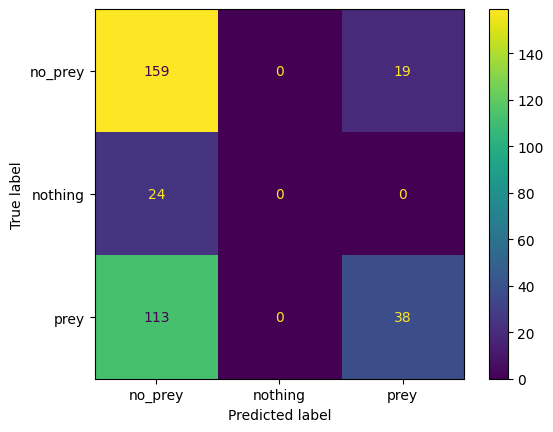

In [201]:
print(classification_report(correct_labels, predicted_labels))

cmat = confusion_matrix(
    np.argmax(correct_labels, axis=-1),
    np.argmax(predicted_labels, axis=-1),
    labels=[0, 1, 2],
)

ConfusionMatrixDisplay(
    confusion_matrix=cmat,
    display_labels=labels
).plot()


In [202]:
labels

['no_prey', 'nothing', 'prey']